# Automated Health Risk Pipeline Analysis

In [7]:
# Libraries
import pandas as pd
from datetime import datetime
from helper_functions import *
import warnings
warnings.filterwarnings("ignore")
from Scoring import *
import matplotlib.pyplot as plt

In [8]:
# To be filled (Input #1)

# Path to raw full data
full_dataset_path = r"C:\Frank\UoT 2024-2025\MIE8888 Project\full_dataset_2.11.csv"

In [9]:
# Preprocessing Data and conduct risk score for each treatment
'''
If the procedure code is 4 digits long:  
Codes starting with 1 or 2 are assigned a risk level of 0.5.  
Codes starting with 3, 4, or 5 are assigned a risk level of 0.  


If the procedure code is 5 digits long, risk levels are assigned based on the first digit:  
Codes starting with 1 get a risk level of 1.  
Codes starting with 2 to 8 have negative risk levels, decreasing incrementally.  
Codes starting with 9 or any other number get a risk level of 0.  
'''

# Load and preprocess dataset
results = pd.read_csv(full_dataset_path, encoding="Windows-1252")

# Calculate patient age at procedure date
results['procedure_date'] = pd.to_datetime(results['procedure_date'], errors='coerce')
results['birth_date'] = pd.to_datetime(results['birth_date'], errors='coerce')
results['age'] = results['procedure_date'].dt.year - results['birth_date'].dt.year
results = results[results['age'] >= 0]  # Remove invalid rows

# Convert and clean date columns
results['first_visit'] = pd.to_datetime(results['first_visit'], errors='coerce')
results[['first_visit', 'procedure_date']] = results[['first_visit', 'procedure_date']].apply(lambda col: col.dt.tz_localize(None))

# Calculate time between first visit and procedure
results['visit_procedure_diff'] = (results['procedure_date'] - results['first_visit']).dt.days
results = results[results['visit_procedure_diff'] >= 7 * 365]  # Keep patients with long histories

# Reset index and extract key dataframes
results.reset_index(drop=True, inplace=True)
treatment_df = results[['patient_id', 'patient', 'procedure_date', 'procedure_code_y']].copy()
patient_df = results[['patient_id', 'patient', 'birth_date', 'first_visit']].drop_duplicates()

# Apply risk level mapping
treatment_df['risk_level'] = treatment_df['procedure_code_y'].apply(assign_risk)

print('Risk level score for each treatment have being added - completed')

Risk level score for each treatment have being added - completed


---
1. Visit Frequency

- **Scoring Logic:**
  - If `Number of Visits > 6`: **Frequency Score = 1**
  - Else if `Number of Visits > 3`: **Frequency Score = 0.7**
  - Else: **Frequency Score = 0.5**

- **Interpretation:**  
  The idea is to assign higher scores to patients who visit more frequently.  
  Frequent visits imply more up-to-date information, and therefore, more weight in analysis.

---

2. Recency Analysis

- **Scoring Logic (based on time since treatment):**
  - If `Within 6 months`: **Recency Weight = 1**
  - Else if `Within 1 year`: **Recency Weight = 0.7**
  - Else if `Within 2 years`: **Recency Weight = 0.5**
  - Else: **Recency Weight = 0.3**

- **Interpretation:**  
  More recent treatments are considered more relevant and are given higher weights.  
  Older treatments receive lower importance in the scoring model.
---

3. Formula for health score calculation:
$$ \sum \text{Each Treatment Risk Score} \times \text{Recency Weight} \times \mathit{Frequency\ Weight} $$
---

In [10]:
# Run the scoring function (This process may take 30-45 mins to run based on current dataset)
result_df = compute_rolling_scores(treatment_df, patient_df)

# drop rows where the time to crowns/root canals are negative but keep the null values
health_scores_with_features_df_c = result_df[(result_df['time_to_crowns'] >= 0) | (result_df['time_to_crowns'].isnull())]
health_scores_with_features_df_c = result_df[(result_df['time_to_root_canal'] >= 0) | (result_df['time_to_root_canal'].isnull())]
health_scores_with_features_df_c.reset_index(drop=True, inplace=True)
unique_patient_ids = health_scores_with_features_df_c['patient_id'].unique()
print('Health scores have been added successfully. One can use the unique patient ids to check the distribution his/her health score change over years')
unique_patient_ids

Health scores have been added successfully. One can use the unique patient ids to check the distribution his/her health score change over years


array([2479, 6970, 6239, ..., 3536, 6988, 6696], dtype=int64)

In [42]:
# To be filled (Input #2) One could check `unique_patient_ids` for available codes
# patient_id = 6239
patient_id = 2479

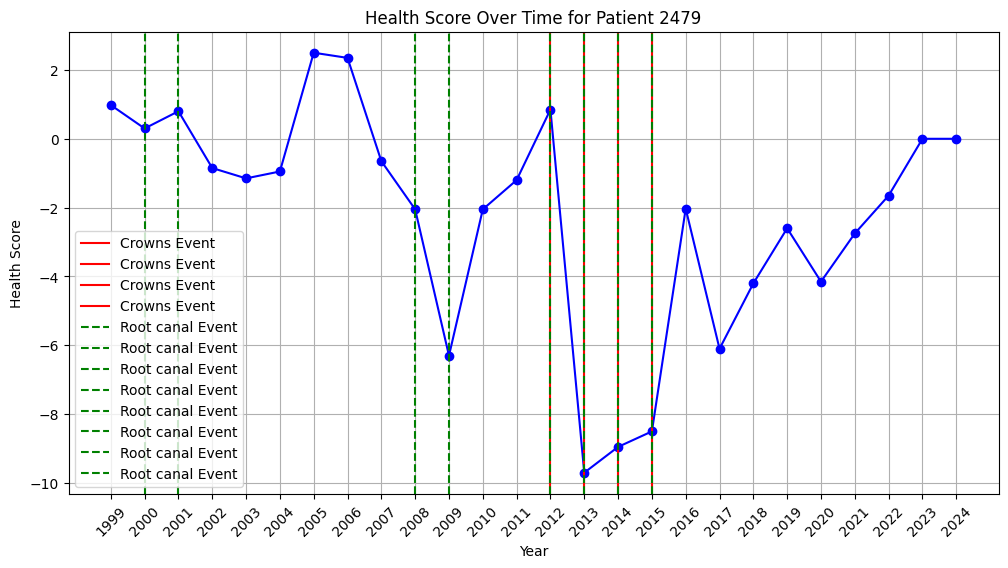

In [43]:
# Click to plot the distribution
patient_health_scores = health_scores_with_features_df_c[health_scores_with_features_df_c['patient_id'] == patient_id]
plt.figure(figsize=(12, 6))
plt.plot(patient_health_scores['year'], patient_health_scores['health_score'], marker='o', color='b')
plt.title(f'Health Score Over Time for Patient {patient_id}')
plt.xlabel('Year')
plt.ylabel('Health Score')

# Add vertical lines for crown events
crowns_events = patient_health_scores[patient_health_scores['time_to_crowns'].notnull()]
for _, event in crowns_events.iterrows():
    plt.axvline(event['year'], color='r', linestyle='-', label='Crowns Event')

root_events = patient_health_scores[patient_health_scores['time_to_root_canal'].notnull()]
for _, event in root_events.iterrows():
    plt.axvline(event['year'], color='g', linestyle='--', label='Root canal Event')

plt.xticks(patient_health_scores['year'].unique(), rotation=45)
plt.legend()
plt.grid(True)
plt.show()